# Gemini API 멀티모달 호출하기

### Install the Python SDK

In [ ]:
!pip install -q -U google-generativeai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.8/160.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.0/760.0 kB 22.6 MB/s eta 0:00:00


### Import packages & Helpers

In [ ]:
import pathlib
import textwrap

import google.generativeai as genai

from IPython.display import display
from IPython.display import Markdown

# Helpers
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

In [ ]:
# Or use `os.getenv('GOOGLE_API_KEY')` to fetch an environment variable.
# GOOGLE_API_KEY="<YOUR GOOGLE API KEY>"
# genai.configure(api_key=GOOGLE_API_KEY)

In [ ]:
# 구글 생성형 AI 라이브러리를 가져옴
import google.generativeai as genai

# 구글 Colab에서 사용자 데이터를 가져오기 위한 모듈을 임포트
from google.colab import userdata

#에러가 발생할 경우 자동으로 재도전하도록 함
from google.api_core import retry

# OS와 상호작용하기 위한 os 모듈을 임포트 (환경 변수나 파일 경로 관리 등에 사용)
import os

# 'GOOGLE_API_KEY' 값을 가져와 API_KEY 변수에 저장
API_KEY = userdata.get('YOUR GOOGLE_API_KEY')

# 구글 생성형 AI 라이브러리 설정을 API_KEY로 구성
genai.configure(api_key=API_KEY)

## 이미지 및 텍스트 입력에서 텍스트 생성하기

Gemini는 텍스트와 이미지 및 입력을 모두 허용하는 멀티모달 모델(`gemini-pro-vision`)을 제공합니다. `GenerativeModel.generate_content` API는 멀티모달 프롬프트를 처리하고 텍스트 출력을 반환하도록 설계되었습니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import PIL.Image

path = '/content'

img = PIL.Image.open(path + '/cat.jpg')
img

gemini-pro-vision` 모델을 사용하고 `generate_content`를 사용하여 이미지를 모델에 전달합니다.

In [ ]:
model = genai.GenerativeModel('gemini-1.5-flash') # 모델을 gemini-1.5-flash로 변경

response = model.generate_content(img)

to_markdown(response.text)

> This is a picture of a cat looking at the camera. It has brown and white fur with green eyes. It is sitting on a concrete surface. The cat is in focus while the background is blurred.

프롬프트에 텍스트와 이미지를 모두 제공하려면 문자열과 이미지가 포함된 목록을 전달 할 수 있습니다.

In [ ]:
response = model.generate_content(["이 사진에 대해 자세히 설명해줘",
                                   img])


In [ ]:
to_markdown(response.text)

> 이 사진은 콘크리트 바닥에 앉아 있는 고양이를 보여줍니다. 고양이는 갈색과 흰색의 털을 가지고 있으며, 노란 눈과 검은 코가 있습니다. 고양이는 카메라를 바라보고 있으며, 조금 겁이 난 듯한 표정을 짓고 있습니다. 고양이의 배경은 흐릿하게 찍혀 있고, 금속 난간이 보입니다. 사진은 고양이의 시선을 통해 찍은 것 같습니다. 전체적으로 사진은 고양이의 귀여움과 신비함을 잘 보여줍니다.

## 멀티모달 프롬프트 설계하기

### 1. 내용 파싱하기

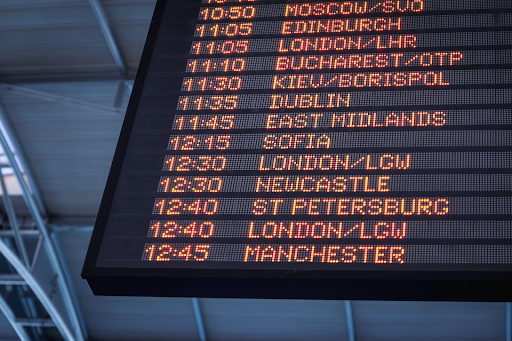

In [ ]:
img = PIL.Image.open(path + '/timetable.png')
img

In [ ]:
response = model.generate_content(["이 사진에 대해 자세히 설명해줘",
                                   img])

In [ ]:
to_markdown(response.text)

> 이 사진은 공항 출발판을 보여줍니다. 출발 시간과 목적지가 표시되어 있습니다. 10:50에서 12:45 사이의 시간을 보여주며, 목적지에는 모스크바, 에든버러, 런던(LHR), 부쿠레슈티, 키예프, 더블린, 이스트 미들랜드, 소피아, 런던(LGW), 뉴캐슬, 상트페테르부르크, 런던(LGW) 및 맨체스터가 있습니다.

In [ ]:
response = model.generate_content(["이 이미지에 표시된 공항 보드의 시간과 도시를 목록으로 파싱합니다.",
                                   img])
to_markdown(response.text)

> - 10:50 MOSCOW
> - 11:05 EDINBURGH
> - 11:05 LONDON/LHR
> - 11:10 BUCHAREST/OTP
> - 11:10 KIEV/BORISPOL
> - 11:35 DUBLIN
> - 11:45 EAST MIDLANDS
> - 12:15 SOFIA
> - 12:30 LONDON/LGW
> - 12:30 NEWCASTLE
> - 12:40 ST PETERSBURG
> - 12:40 LONDON/LGW
> - 12:45 MANCHESTER

### 2. 단계별로 분석하기

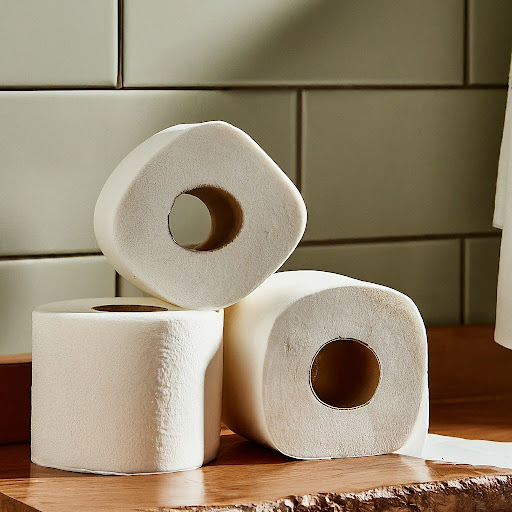

In [ ]:
img = PIL.Image.open(path + '/toilet-paper.jpg')
img

In [ ]:
response = model.generate_content(["화장실 휴지 몇개야?",
                                   img])
to_markdown(response.text)

> 사진에는 화장지가 3개 있습니다.

In [ ]:
text = """\
1. 먼저 이 사진에 화장지 롤이 몇 개인지 세세요.
2. 그런 다음 보통 사람이 하루에 사용하는 화장지 양을 결정합니다.
3. 이 화장지 롤의 지속 시간을 계산하세요."""

response = model.generate_content([text,
                                   img])
to_markdown(response.text)

> 1. 사진에는 화장지 롤이 3개 있습니다.
> 2. 일반적으로 사람은 하루에 화장지 2~3장을 사용합니다.
> 3. 화장지 롤에 100장이 있다고 가정하면 3개의 롤은 300장으로, 약 100일 동안 사용할 수 있습니다. 따라서 이 화장지 롤은 약 100일 동안 사용할 수 있습니다.

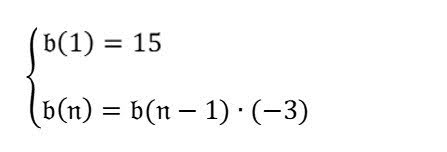

In [ ]:
img = PIL.Image.open(path + '/math.jpg')
img

In [ ]:
response = model.generate_content(["순열의 n=4일 때 값",
                                   img])
to_markdown(response.text)

> The given recurrence relation is:
> ```
> b(1) = 15
> b(n) = b(n-1) * (-3)
> ```
> 
> To find the value of b(4), we can use this recurrence relation iteratively:
> 
> * **b(2) = b(1) * (-3) = 15 * (-3) = -45**
> * **b(3) = b(2) * (-3) = -45 * (-3) = 135**
> * **b(4) = b(3) * (-3) = 135 * (-3) = -405**
> 
> Therefore, the value of b(4) is **-405**.

In [ ]:
text="""\
먼저 이미지의 수식을 파싱합니다.

그런 다음 공식에 따라 '순서의 네 번째 항은 무엇인가요?'라고 답하세요."""
response = model.generate_content([text,
                                   img])
to_markdown(response.text)

> 이것은 재귀적 시퀀스입니다.
> 
> b(1) = 15이므로 첫 번째 항은 15입니다.
> 
> b(n) = b(n-1) * (-3)이므로 각 항은 이전 항에 -3을 곱한 값입니다.
> 
> 따라서 시퀀스는 다음과 같습니다.
> 15, -45, 135, -405 ...
> 
> 따라서 시퀀스의 네 번째 항은 **-405**입니다.

### 3. 출력 형식을 지정하기

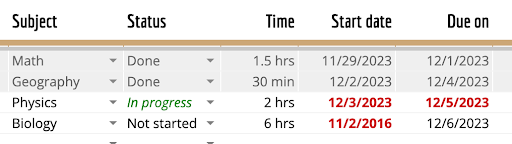

In [ ]:
img = PIL.Image.open(path + '/excel-example.png')
img

In [ ]:
response = model.generate_content(["이 이미지의 테이블을 마크다운 형식으로 파싱합니다.",
                                   img])
to_markdown(response.text)

> | Subject   | Status        | Time   | Start date | Due on    |
> |-----------|----------------|--------|------------|-----------|
> | Math      | Done          | 1.5 hrs | 11/29/2023 | 12/1/2023 |
> | Geography | Done          | 30 min | 12/2/2023 | 12/4/2023 |
> | Physics   | *In progress* | 2 hrs  | 12/3/2023 | 12/5/2023 |
> | Biology   | Not started   | 6 hrs  | 11/2/2016 | 12/6/2023 |

In [ ]:
response = model.generate_content(["이 이미지의 테이블을 마크다운 json으로 파싱합니다.",
                                   img])
to_markdown(response.text)

> ```json
> [
>   {
>     "Subject": "Math",
>     "Status": "Done",
>     "Time": "1.5 hrs",
>     "Start date": "11/29/2023",
>     "Due on": "12/1/2023"
>   },
>   {
>     "Subject": "Geography",
>     "Status": "Done",
>     "Time": "30 min",
>     "Start date": "12/2/2023",
>     "Due on": "12/4/2023"
>   },
>   {
>     "Subject": "Physics",
>     "Status": "In progress",
>     "Time": "2 hrs",
>     "Start date": "12/3/2023",
>     "Due on": "12/5/2023"
>   },
>   {
>     "Subject": "Biology",
>     "Status": "Not started",
>     "Time": "6 hrs",
>     "Start date": "11/2/2016",
>     "Due on": "12/6/2023"
>   }
> ]
> ```